<a href="https://colab.research.google.com/github/yashikart/Blood-Group-Detection-Using-Fingerprints/blob/main/Image_Preprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install fingerprint-feature-extractor

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint-feature-extractor: filename=fingerprint_feature_extractor-0.0.10-py3-none-any.whl size=4829 sha256=204bd24b08a2c2ba4660b87d4b8e7553d4df450df51a789abfb3863db67b6825
  Stored in directory: /root/.cache/pip/wheels/30/85/fd/31e1eefbb140c9a611a41c2819bd2186e1384c108eff4d10e1
Successfully built fingerprint-feature-extractor


In [6]:
!pip install fingerprint_enhancer

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.14-py3-none-any.whl size=10628 sha256=e6394642991c6d076ccf46321350e12a99099d7219f70530ad9591db8beac63e
  Stored in directory: /root/.cache/pip/wheels/3b/de/af/ea18bac41054916ac77ae32dfb8544155d758734b91266315d
Successfully built fingerprint_enhancer


In [14]:
import cv2
from fingerprint_enhancer.fingerprint_image_enhancer import FingerprintImageEnhancer
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math
import skimage.measure
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

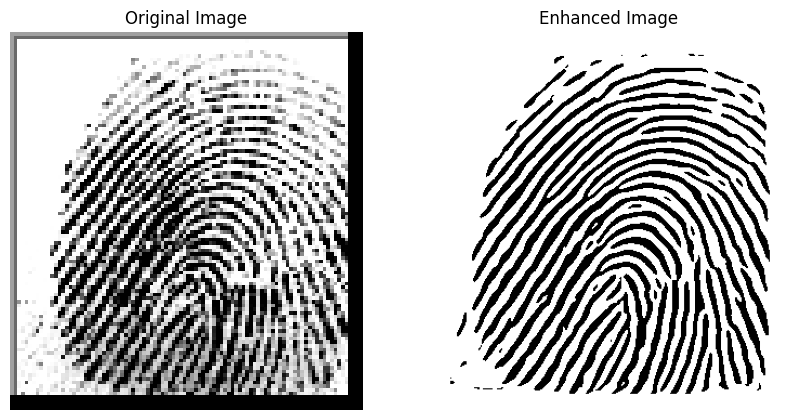

In [13]:
class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def showResults(self, FeaturesTerm, FeaturesBif):

        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        cv2.imshow('output', DispImg)
        cv2.waitKey(0)

    def saveResult(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        cv2.imwrite('result.png', DispImg)

if __name__ == "__main__":
    image_enhancer = FingerprintImageEnhancer()  # Create object called image_enhancer
    if len(sys.argv) < 2:  # load input image
        print("loading sample image")
         # Changed to only filename
        image_path = "/content/drive/MyDrive/Blood Group Detection/Renamed_Images/O+_cluster_6_5651.BMP"
        img = cv2.imread(image_path) # Load with full path
    elif len(sys.argv) >= 2:
        IMG_NAME = sys.argv[1]
        image_path = "/content/drive/MyDrive/Blood Group Detection/Renamed_Images/O+_cluster_6_5651.BMP"
        img = cv2.imread(image_path) # Load with full path

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        sys.exit(1)  # Exit if image loading fails

    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    image_enhancer.enhance(img, invert_output=True)
    image_enhancer.save_enhanced_image("/content/drive/MyDrive/Blood Group Detection/enhanced.BMP")  # save output
    enhancer = image_enhancer.enhance(img, invert_output=True)
    # Display Input and Output Side by Side
    plt.figure(figsize=(10, 5))

    # Show Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Show Enhanced Image
    plt.subplot(1, 2, 2)
    plt.imshow(enhancer, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.show()

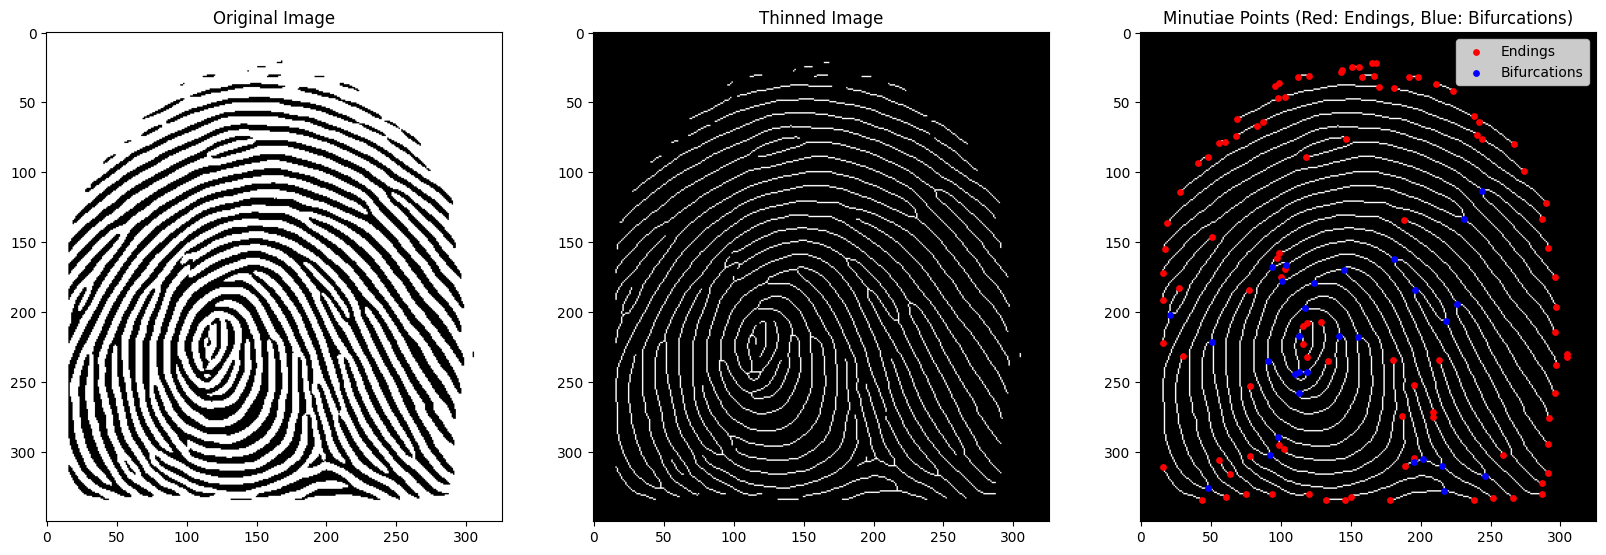

Total Ridge Endings: 100
Total Bifurcations: 30


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

def enhance_fingerprint(image_path):
    """Enhance fingerprint image by applying adaptive thresholding."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return binary

def thin_fingerprint(binary_image):
    """Perform thinning (skeletonization) on the fingerprint image."""
    skeleton = skeletonize(binary_image > 0)
    return (skeleton * 255).astype(np.uint8)

def extract_minutiae(skeleton_image):
    """Extract minutiae using the crossing number method."""
    endings = []
    bifurcations = []

    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1),
                 (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]  # Loop back to the first neighbor

    for i in range(1, skeleton_image.shape[0] - 1):
        for j in range(1, skeleton_image.shape[1] - 1):
            if skeleton_image[i, j] == 255:
                block = [skeleton_image[i + dx, j + dy] for dx, dy in neighbors]
                transitions = sum((block[k] == 0 and block[k + 1] == 255) for k in range(8))

                if transitions == 1:
                    endings.append((j, i))  # Ridge ending
                elif transitions == 3:
                    bifurcations.append((j, i))  # Bifurcation

    return endings, bifurcations

def visualize_results(original, enhanced, thinned, endings, bifurcations):
    """Visualize fingerprint processing results."""
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(thinned, cmap='gray')
    plt.title("Thinned Image")

    plt.subplot(1, 3, 3)
    plt.imshow(thinned, cmap='gray')

    # Plot ridge endings in red
    plt.scatter([x for x, y in endings], [y for x, y in endings], c='red', s=15, label='Endings')

    # Plot bifurcations in blue
    plt.scatter([x for x, y in bifurcations], [y for x, y in bifurcations], c='blue', s=15, label='Bifurcations')

    plt.legend()
    plt.title("Minutiae Points (Red: Endings, Blue: Bifurcations)")

    plt.show()

def process_fingerprint(image_path):
    """Complete fingerprint recognition pipeline."""
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    binary = enhance_fingerprint(image_path)
    thinned = thin_fingerprint(binary)
    endings, bifurcations = extract_minutiae(thinned)
    visualize_results(original, binary, thinned, endings, bifurcations)
    return thinned, endings, bifurcations

if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/Blood Group Detection/enhanced6.BMP"
    thinned_image, ridge_endings, bifurcation_points = process_fingerprint(image_path)

    print(f"Total Ridge Endings: {len(ridge_endings)}")
    print(f"Total Bifurcations: {len(bifurcation_points)}")
